In [19]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import os

import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# early stopping
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# VGG16 모델 불러오기 (사전 학습된 가중치 사용, fully connected layer 포함)
base_model = VGG16(weights='imagenet')



In [20]:
# 데이터셋 경로 지정
train_horse_dir = './data/train_added/horses'
train_human_dir = './data/train_added/humans'

In [21]:
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

In [22]:
horse_files = [train_horse_dir + '/' + f for f in train_horse_names]
human_files = [train_human_dir + '/' + f for f in train_human_names]

In [23]:
model = Sequential()
model.add(base_model)  # VGG16 기반
# model.add(Flatten())  # 특징 맵을 1차원으로 변환
model.add(Dense(256, activation='relu'))  # 새로운 Fully Connected Layer 추가
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 출력층

# 기존 VGG16의 가중치를 고정
base_model.trainable = True
for layer in base_model.layers[:-4]:  # 마지막 4개의 레이어만 훈련 가능하게 설정
    layer.trainable = False

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=1e-5),
            metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1000)           │   138,357,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,614,057 (528.77 MB)

 Trainable params: 123,899,369 (472.64 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
# 이미지 값을 0~1 사이로 제한
train_datagen = ImageDataGenerator(rescale=1/255)

# train set
train_generator = train_datagen.flow_from_directory(
  './data/train_added/',
  target_size=(224, 224),  # 해상도 조절
  batch_size=128,  # 배치 크기
  class_mode='binary'  # 분류 방법
)

# valid set
valid_generator = train_datagen.flow_from_directory(
  './data/validation-horse-or-human/',
  target_size=(224, 224),
  batch_size=128,
  class_mode='binary'
)

# 얼리스토핑 초기화
es = EarlyStopping(
    monitor='loss',
    patience=3
)

# 모델 체크포인트 초기화
checkpoint = ModelCheckpoint(
    filepath = './checkpoint.keras',
    verbose = 2,
    save_best_only = True,
    mode = 'auto'
)

# steps_per_epoch 설정
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size


# 모델 학습
history = model.fit(
  train_generator,
  steps_per_epoch = train_generator.samples // train_generator.batch_size,
  epochs=15,
  verbose=1,
  callbacks=[checkpoint, es]
)

Found 2890 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.5405 - loss: 0.6923
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 330us/step - accuracy: 0.6641 - loss: 0.6895
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.7284 - loss: 0.6856
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 744us/step - accuracy: 0.7812 - loss: 0.6804
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.8313 - loss: 0.6765
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 0s/step - accuracy: 0.8438 - loss: 0.6760  
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - accuracy: 0.8547 - loss: 0.6733
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 453us/step - accuracy: 0.8906 - loss: 0.6714
Epoch 9/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.8885 - loss: 0.6698
Epoch 10/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 745us/step - accuracy: 0.8516 - loss: 0.6692
Epoch 11/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy

In [25]:
# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.9323 - loss: 0.6650
test loss, test acc: [0.6649233102798462, 0.93359375]


In [26]:
# 이미지 전처리
dlist = './data/test-horse-or-human/'
predict_list = os.listdir(dlist)
print(predict_list)

img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (224,224)) for i in img]
img = np.array(img)
img = img.astype('float32') / 255.0

# 분류
cutoff = .5
predictions = model.predict(img)
print(predictions >= cutoff)

['horse1.jpg', 'horse2.webp', 'horse3.jpg', 'human1.jpg', 'human2.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
[[False]
 [False]
 [ True]
 [ True]
 [ True]]


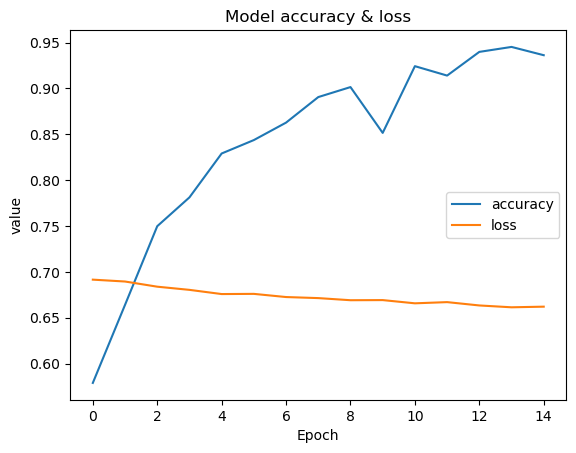

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()